<h2 align=center> Optimize TensorFlow Models For Deployment with TensorRT</h2>

In this project, you will learn how to use the TensorFlow integration for TensorRT (also known as TF-TRT) to increase inference performance.

### Learning Objectives

By the time you complete this project, you will be able to:

- Optimize Tensorflow models using TF-TRT
- Use TF-TRT to optimize several deep learning models at FP32, FP16, and INT8 precision
- Observe how tuning TF-TRT parameters affects performance and inference throughput


### Prerequisites

In order to be successful with this project, it is assumed you are:

- Competent in the Python programming language
- Familiar with Deep Learning, and understand what **inference** is
- Familiar with TensorFlow, and its Keras API

### Contents

This project/notebook consists of several Tasks.

- **[Task 1]()**: Introduction to the Project.
- **[Task 2]()**: Setup your TensorFlow and TensorRT Runtime
- **[Task 3]()**: Load the Data and Pre-trained Model
- **[Task 4]()**: Create Batched Input
- **[Task 5]()**: Load TensorFlow SavedModel
- **[Task 6]()**: Get Baseline for Prediction Throughput and Accuracy
- **[Task 7]()**: Convert a TensorFlow saved model into a TF-TRT Float32 Optimized Graph
- **[Task 8]()**: Benchmark TF-TRT Float32
- **[Task 9]()**: Convert to TF-TRT Float16 and Benchmark
- **[Task 10]()**: TF-TRT INT8 Model
- **[Task 11]()**: Converting to TF-TRT INT8
- **[Task 12]()**: Benchmark TF-TRT INT8

## Task 2: Setup your TensorFlow and TensorRT Runtime.

You will only be able to use the Colab Notebook after you save it to your Google Drive folder. Click on the File menu and select “Save a copy in Drive…

![Copy to Drive](https://drive.google.com/uc?id=1CH3eDmuJL8WR0AP1r3UE6sOPuqq8_Wl7)


## Check GPU Availability

Check if your Colab notebook is configured to use Graphical Processing Units (GPUs). If zero GPUs are available, check if the Colab notebook is configured to use GPUs (Menu > Runtime > Change Runtime Type).

![Hardware Accelerator Settings](https://drive.google.com/uc?id=1qrihuuMtvzXJHiRV8M7RngbxFYipXKQx)


In [1]:
!nvidia-smi

Thu Oct 15 02:45:34 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.23.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Install TensorFlow-GPU 2.0 and TensorRT Runtime

In [2]:
%%bash
wget -q https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64/nvidia-machine-learning-repo-ubuntu1804_1.0.0-1_amd64.deb

dpkg -i nvidia-machine-learning-repo-*.deb
apt-get -qq update

sudo apt-get -qq install libnvinfer5 #libnvinfer6=6.0.1-1+cuda10.1

pip install -q tensorflow-gpu==2.0.0

(Reading database ... 144638 files and directories currently installed.)
Preparing to unpack nvidia-machine-learning-repo-ubuntu1804_1.0.0-1_amd64.deb ...
Unpacking nvidia-machine-learning-repo-ubuntu1804 (1.0.0-1) over (1.0.0-1) ...
Setting up nvidia-machine-learning-repo-ubuntu1804 (1.0.0-1) ...


W: Target Packages (Packages) is configured multiple times in /etc/apt/sources.list.d/nvidia-machine-learning.list:1 and /etc/apt/sources.list.d/nvidia-ml.list:1
W: Target Packages (Packages) is configured multiple times in /etc/apt/sources.list.d/nvidia-machine-learning.list:1 and /etc/apt/sources.list.d/nvidia-ml.list:1
W: Target Packages (Packages) is configured multiple times in /etc/apt/sources.list.d/nvidia-machine-learning.list:1 and /etc/apt/sources.list.d/nvidia-ml.list:1


In [3]:
# check TensorRT version
import tensorflow as tf
print("TensorFlow version: ", tf.version.VERSION)
print("TensorRT version: ")
!dpkg -l | grep nvinfer

TensorFlow version:  2.0.0
TensorRT version: 
ii  libnvinfer5                             5.1.5-1+cuda10.1                      amd64        TensorRT runtime libraries


A successfull TensorRT installation looks like:

```
TensorFlow version:  2.0.0
TensorRT version: 
ii  libnvinfer5   5.1.5-1+cuda10.1   amd64        TensorRT runtime libraries
```

## Restart the Runtime

**Note** 
After installing the required Python packages, you'll need to restart the Colab Runtime Engine (Menu > Runtime > Restart runtime...)

![Restart of the Colab Runtime Engine](https://drive.google.com/uc?id=1xnjAy2sxIymKhydkqb0RKzgVK9rh3teH)



### Importing required libraries

In [1]:
# Re-run after Kernel restart
from __future__ import absolute_import, division, print_function, unicode_literals
import os
import time

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.python.compiler.tensorrt import trt_convert as trt
from tensorflow.python.saved_model import tag_constants
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input, decode_predictions

## Task 3: Load the Data and Pre-trained Model

### Data
We download several random images for testing from the Internet.

In [5]:
!mkdir ./data
!wget  -qO ./data/img0.JPG "https://upload.wikimedia.org/wikipedia/commons/thumb/9/93/Golden_Retriever_Carlos_%2810581910556%29.jpg/640px-Golden_Retriever_Carlos_%2810581910556%29.jpg"
!wget  -qO ./data/img1.JPG "https://upload.wikimedia.org/wikipedia/commons/thumb/6/62/Red-shouldered_Hawk_%28Buteo_lineatus%29_-_Blue_Cypress_Lake%2C_Florida.jpg/407px-Red-shouldered_Hawk_%28Buteo_lineatus%29_-_Blue_Cypress_Lake%2C_Florida.jpg"
!wget  -qO ./data/img2.JPG "https://upload.wikimedia.org/wikipedia/commons/thumb/2/28/Ostrich_male_RWD.jpg/636px-Ostrich_male_RWD.jpg"
!wget  -qO ./data/img3.JPG "https://upload.wikimedia.org/wikipedia/commons/thumb/e/ed/Working_pay_phone%2C_Jensen_Beach%2C_Florida%2C_September_4%2C_2012_001.JPG/360px-Working_pay_phone%2C_Jensen_Beach%2C_Florida%2C_September_4%2C_2012_001.JPG"

mkdir: cannot create directory ‘./data’: File exists


### Model

Thoughout this project, we will be using InceptionV3. Here we import the model from Keras.

In [6]:
model = InceptionV3(weights='imagenet')

./data/img0.JPG - Predicted: [('n02099601', 'golden_retriever', 0.6146083), ('n02099712', 'Labrador_retriever', 0.2392583), ('n02104029', 'kuvasz', 0.006721575)]
./data/img1.JPG - Predicted: [('n01608432', 'kite', 0.98407656), ('n01807496', 'partridge', 0.00094867276), ('n01806567', 'quail', 0.00046502193)]
./data/img2.JPG - Predicted: [('n01518878', 'ostrich', 0.9310745), ('n02018795', 'bustard', 0.002101431), ('n02437616', 'llama', 0.0008443303)]
./data/img3.JPG - Predicted: [('n03902125', 'pay-phone', 0.98850507), ('n03187595', 'dial_telephone', 0.009468648), ('n02977058', 'cash_machine', 2.3739327e-05)]


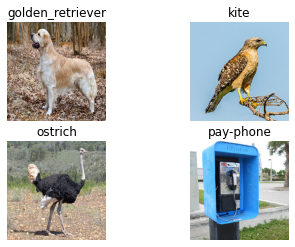

In [7]:
def show_predictions(model):
  for i in range(4):
    img_path = './data/img%d.JPG'%i
    img = image.load_img(img_path, target_size=(299, 299))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)

    preds = model.predict(x)
    print('{} - Predicted: {}'.format(img_path, decode_predictions(preds, top=3)[0]))

    plt.subplot(2,2,i+1)
    plt.imshow(img);
    plt.axis('off');
    plt.title(decode_predictions(preds, top=3)[0][0][1])
show_predictions(model)

When we benchmark our optimized TF-TRT models, they will be saved TensorFlow (not Keras) models. In order to have a fair comparison, here we save our Keras model as a TensorFlow model

In [9]:
# Save the entire model as a TensorFlow SavedModel.


In [8]:
tf.saved_model.save(model, 'inceptionv3_saved_model')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: inceptionv3_saved_model/assets


In [9]:
!saved_model_cli show --all --dir inceptionv3_saved_model/


MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['__saved_model_init_op']:
  The given SavedModel SignatureDef contains the following input(s):
  The given SavedModel SignatureDef contains the following output(s):
    outputs['__saved_model_init_op'] tensor_info:
        dtype: DT_INVALID
        shape: unknown_rank
        name: NoOp
  Method name is: 

signature_def['serving_default']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['input_1'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 299, 299, 3)
        name: serving_default_input_1:0
  The given SavedModel SignatureDef contains the following output(s):
    outputs['predictions'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 1000)
        name: StatefulPartitionedCall:0
  Method name is: tensorflow/serving/predict


## Task 4: Create Batched Input

Using **batch inference** to send many images to the GPU at once promotes parallel processing and improve throughput.

The `batch_input` helper function takes a batch_size, and returns a tensor with the preprocessed images.

In [2]:
# Re-run after Kernel restart

def batch_input(batch_size = 8):
  batched_input = np.zeros((batch_size, 299,299,3), dtype=np.float32)

  for i in range(batch_size):
    img_path = './data/img%d.JPG' % (i%4)
    img = image.load_img(img_path, target_size=(299,299))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    batched_input[i,:]=x

    batched_input = tf.constant(batched_input)
    return batched_input


In [3]:
# Re-run after Kernel restart
batched_input = batch_input(batch_size=32)

In [12]:
type(batched_input)

tensorflow.python.framework.ops.EagerTensor

In [13]:
batched_input.shape

TensorShape([32, 299, 299, 3])

## Task 5: Load TensorFlow SavedModel

In [4]:
# Re-run after Kernel restart

def load_tf_saved_model(input_saved_model_dir):
  print(f'Loading saved model {input_saved_model_dir}...')
  saved_model_loaded = tf.saved_model.load(input_saved_model_dir, tags = [tag_constants.SERVING])
  return saved_model_loaded


Here we load a previously saved InceptionV3 model.

In [15]:
saved_model = load_tf_saved_model('inceptionv3_saved_model')

Loading saved model inceptionv3_saved_model...


In [16]:
infer = saved_model.signatures['serving_default']
print(infer.structured_outputs)

{'predictions': TensorSpec(shape=(None, 1000), dtype=tf.float32, name='predictions')}


## Task 6: Get Baseline for Prediction Throughput and Accuracy

### Naive Inference with TensorFlow 2

The following will serve as a baseline for prediction throughput and accuracy. Now we perform inference with the optimized graph, and after a warmup, time and calculate throughput.

The helper function `predict_and_benchmark_throughput` will use the passed in model to perform predictions on the passed in batched input over a number of runs. It measures and reports throughput, as well as time for ranges of runs.

Due to GPU initialization operations, we do not want to profile against initial inference -- so we can set a number of warmup runs to perform prior to benchmarking.

`predict_and_benchmark_throughput` returns the predictions for all images for all runs, after the warmup.

In [5]:
# Re-run after Kernel restart

def predict_and_benchmark_throughput(batched_input, infer, N_warmup_run=50, N_run=1000):

  elapsed_time = []
  all_preds = []
  batch_size = batched_input.shape[0]

  for i in range(N_warmup_run):
    labeling = infer(batched_input)
    preds = labeling['predictions'].numpy()

  for i in range(N_run):
    start_time = time.time()

    labeling = infer(batched_input)

    preds = labeling['predictions'].numpy()

    end_time = time.time()

    elapsed_time = np.append(elapsed_time, end_time - start_time)
    
    all_preds.append(preds)

    if i % 50 == 0:
      print('Steps {}-{} average: {:4.1f}ms'.format(i, i+50, (elapsed_time[-50:].mean()) * 1000))

  print('Throughput: {:.0f} images/s'.format(N_run * batch_size / elapsed_time.sum()))
  return all_preds

In [18]:
all_preds= predict_and_benchmark_throughput(batched_input, infer, 
                                            N_warmup_run=50,
                                            N_run=1000)

Steps 0-50 average: 76.4ms
Steps 50-100 average: 76.1ms
Steps 100-150 average: 75.5ms
Steps 150-200 average: 75.6ms
Steps 200-250 average: 75.0ms
Steps 250-300 average: 74.5ms
Steps 300-350 average: 75.2ms
Steps 350-400 average: 75.8ms
Steps 400-450 average: 75.6ms
Steps 450-500 average: 75.2ms
Steps 500-550 average: 75.8ms
Steps 550-600 average: 75.9ms
Steps 600-650 average: 75.1ms
Steps 650-700 average: 74.9ms
Steps 700-750 average: 75.1ms
Steps 750-800 average: 75.5ms
Steps 800-850 average: 74.6ms
Steps 850-900 average: 75.2ms
Steps 900-950 average: 75.8ms
Steps 950-1000 average: 75.8ms
Throughput: 425 images/s


### Observe Accuracy

**NOTE:** We are not so concerned in this project about the accuracy of our predictions per se, only that they remain consistent as we optimize our models.

In [6]:
# Re-run after Kernel restart
def show_predictions(model):

  img_path = './data/img0.JPG'  # golden_retriever
  img = image.load_img(img_path, target_size=(299, 299))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)
  x = tf.constant(x)

  labeling = model(x)
  preds = labeling['predictions'].numpy()
  
  # decode the results into a list of tuples (class, description, probability)
  # (one such list for each sample in the batch)
  print('{} - Predicted: {}'.format(img_path, decode_predictions(preds, top=3)[0]))
  plt.subplot(2,2,1)
  plt.imshow(img);
  plt.axis('off');
  plt.title(decode_predictions(preds, top=3)[0][0][1])

./data/img0.JPG - Predicted: [('n02099601', 'golden_retriever', 0.6146083), ('n02099712', 'Labrador_retriever', 0.2392583), ('n02104029', 'kuvasz', 0.006721575)]


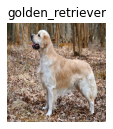

In [22]:
show_predictions(infer)

Before going to the next Task, please execute the cell below to restart the kernel and clear GPU memory.

In [9]:
import IPython
IPython.Application.instance().kernel.do_shutdown(True)

{'restart': True, 'status': 'ok'}

### Network Transformation

TF-TRT performs several important transformations and optimizations to the neural network graph. First, layers with unused outputs are eliminated to avoid unnecessary computation. Next, where possible, convolution, bias, and ReLU layers are fused to form a single layer. 

**Figure (a)** shows a typical convolutional network before optimization and 

**Figure (c)** shows the result of this vertical layer fusion on the original network from Figure (a) (fused layers are labeled CBR). Layer fusion improves the efficiency of running TF-TRT networks on the GPU.

**Figure (b)** Another transformation is horizontal layer fusion, or layer aggregation, along with the required division of aggregated layers to their respective outputs, as Figure (b) shows.

Horizontal layer fusion improves performance by combining layers that take the same source tensor and apply the same operations with similar parameters, resulting in a single larger layer for higher computational efficiency. The example in Figure (b) shows the combination of 3 1×1 CBR layers from Figure (c) that take the same input into a single larger 1×1 CBR layer. Note that the output of this layer must be disaggregated to feed into the different subsequent layers from the original input graph.

*Source*: [Speed up TensorFlow Inference on GPUs with TensorRT](https://blog.tensorflow.org/2018/04/speed-up-tensorflow-inference-on-gpus-tensorRT.html)

<div align="center">
    <img width="700px" src='https://2.bp.blogspot.com/-nc-poLV8CNc/XhOI1wfgGjI/AAAAAAAACQI/3FlNTSKKrqMyTzR5XC5RCNnVuUY5EGmhQCLcBGAsYHQ/s1600/fig2.png' />
    <p style="text-align: center;color:gray">Figure (a): An example convolutional  model with multiple convolutional and activation layers before optimization</p>
    <p style="text-align: center;color:gray">Figure (c): Horizontal layer fusion</p>
</div>

[Source](https://www.slideshare.net/cfregly/advanced-spark-and-tensorflow-meetup-20170506-reduced-precision-fp16-int8-inference-on-convolutional-neural-networks-with-tensorrt-and-nvidia-pascal-from-chris-gottbrath-nvidia): Advanced Spark and TensorFlow Meetup 2017-05-06 Reduced Precision (FP16, INT8) Inference on Convolutional Neural Networks with TensorRT and NVIDIA Pascal from Chris Gottbrath, Nvidia 

<div align="center">
    <img width="600px" src='https://image.slidesharecdn.com/tensorrt-for-spark-tensorflow-meetup-final-170408190710/95/advanced-spark-and-tensorflow-meetup-20170506-reduced-precision-fp16-int8-inference-on-convolutional-neural-networks-with-tensorrt-and-nvidia-pascal-from-chris-gottbrath-nvidia-45-638.jpg' />
    <p style="text-align: center;color:gray"> Figure (c). Horizontal layer fusion </p>
</div>

When optimizing a TensorFlow model, TF-TRT can optimize either a subgraph or the entire graph definition. This capability allows the optimization procedure to be applied to the graph where possible and skip the non-supported graph segments. As a result, if the existing model contains a non-supported layer or operation, TensorFlow can still optimize the graph. 

Please see the [TF-TRT User Guide](https://docs.nvidia.com/deeplearning/frameworks/tf-trt-user-guide/index.html#supported-ops) for a full list of supported operators.

## TF-TRT Workflow:

Below, you can see a typical workflow of TF-TRT:

[Source](https://medium.com/tensorflow/high-performance-inference-with-tensorrt-integration-c4d78795fbfe): High performance inference with TensorRT Integration

<div align="center">
    <img width="600px" src='https://miro.medium.com/max/875/1*hD_4k9bTEXnjuLHcaoFQRQ.png' />
</div>

<div align="center">
    <img width="600px" src='https://miro.medium.com/max/875/1*DwxO-QF6Bz-H4aurRBIrjw.png' />
</div>

We now turn to the syntax for this one additional Optimize with TF-TRT step.

## Graph Conversion

To perform graph conversion, we use `TrtGraphConverterV2`, passing it the directory of a saved model, and any updates we wish to make to its conversion parameters.

```python
from tensorflow.python.compiler.tensorrt import trt_convert as trt

trt.TrtGraphConverterV2(
    input_saved_model_dir=None,
    conversion_params=TrtConversionParams(precision_mode='FP32',
                                          max_batch_size=1
                                          minimum_segment_size=3,
                                          max_workspace_size_bytes=8000000000,
                                          use_calibration=True,
                                          maximum_cached_engines=1,
                                          is_dynamic_op=True,
                                          rewriter_config_template=None,
                                         )
```

### Conversion Parameters

Here is additional information about the most frequently adjusted conversion parameters.

* __precision_mode__: This parameter sets the precision mode; which can be one of FP32, FP16, or INT8. Precision lower than FP32, meaning FP16 and INT8, would improve the performance of inference. The FP16 mode uses Tensor Cores or half precision hardware instructions, if possible. The INT8 precision mode uses integer hardware instructions.

* __max_batch_size__: This parameter is the maximum batch size for which TF-TRT will optimize. At runtime, a smaller batch size may be chosen, but, not a larger one.

* __minimum_segment_size__: This parameter determines the minimum number of TensorFlow nodes in a TF-TRT engine, which means the TensorFlow subgraphs that have fewer nodes than this number will not be converted to TensorRT. Therefore, in general, smaller numbers such as 5 are preferred. This can also be used to change the minimum number of nodes in the optimized INT8 engines to change the final optimized graph to fine tune result accuracy.

* __max_workspace_size_bytes__: TF-TRT operators often require temporary workspace. This parameter limits the maximum size that any layer in the network can use. If insufficient scratch is provided, it is possible that TF-TRT may not be able to find an implementation for a given layer.

# Task 7: Convert a TensorFlow saved model into a TF-TRT Float32 Graph

Convert a TensorFlow saved model into a TF-TRT optimized graph using Float32 precision. We will use the optimized graph to make predictions and will benchmark its performance.

Only a few lines of code are needed to use TF-TRT
```python
from tensorflow.python.compiler.tensorrt import trt_convert as trt

conversion_params = trt.DEFAULT_TRT_CONVERSION_PARAMS._replace(
  precision_mode=trt.TrtPrecisionMode.<FP16 or FP32>
  max_workspace_bytes=8000000000
)

converter = trt.TrtGraphConverterV2(
  input_saved_model_dir=input_saved_model_dir,
  conversion_params=conversion_params
)

converter.convert()

converter.save(output_saved_model_dir)
```

In [9]:
# Re-run after Kernel restart

def convert_to_trt_graph_and_save(precision_mode='float32',
                                  input_saved_model_dir='inceptionv3_saved_model',
                                  calibration_data=batched_input):
  if precision_mode == 'float32':
    precision_mode= trt.TrtPrecisionMode.FP32
    converted_save_suffix= '_TFTRT_FP32'

  if precision_mode == 'float16':
    precision_mode= trt.TrtPrecisionMode.FP16
    converted_save_suffix= '_TFTRT_FP16'
  
  if precision_mode == 'int8':
    precision_mode= trt.TrtPrecisionMode.INT8
    converted_save_suffix= '_TFTRT_INT8'
  
  output_saved_model_dir = input_saved_model_dir + converted_save_suffix

  conversion_params = trt.DEFAULT_TRT_CONVERSION_PARAMS._replace(
      precision_mode= precision_mode,
      max_workspace_size_bytes = 8000000000
  )

  converter =  trt.TrtGraphConverterV2(
      input_saved_model_dir = input_saved_model_dir,
      conversion_params=conversion_params
  )

  print(f'Converting {input_saved_model_dir} to TF-TRT graph precision mode {precision_mode}...')

  if precision_mode == trt.TrtPrecisionMode.INT8:
    def calibration_input_fn():
      yield (calibration_data, )
    converter.convert(calibration_input_fn = calibration_input_fn)



  else:
    converter.convert()

  print(f'Saving converted model to {output_saved_model_dir}')
  converter.save(output_saved_model_dir= output_saved_model_dir)
  print('Conversion complete')

In [24]:
convert_to_trt_graph_and_save(precision_mode='float32',input_saved_model_dir='inceptionv3_saved_model')

INFO:tensorflow:Linked TensorRT version: (5, 1, 5)
INFO:tensorflow:Loaded TensorRT version: (5, 1, 5)
INFO:tensorflow:Running against TensorRT version 5.1.5
Converting inceptionv3_saved_model to TF-TRT graph precision mode FP32...
Saving converted model to inceptionv3_saved_model_TFTRT_FP32
INFO:tensorflow:Assets written to: inceptionv3_saved_model_TFTRT_FP32/assets
Conversion complete


## Task 8: Benchmark TF-TRT Float32

Load the optimized TF model.

In [25]:
saved_model_loaded = load_tf_saved_model('/content/inceptionv3_saved_model_TFTRT_FP32')

Loading saved model /content/inceptionv3_saved_model_TFTRT_FP32...


In [26]:
infer = saved_model_loaded.signatures['serving_default']

Perform inference with the optimized graph, and after a warmup, time and calculate throughput.

In [27]:
all_preds= predict_and_benchmark_throughput(batched_input, infer, N_warmup_run=50, N_run=1000)

Steps 0-50 average: 57.5ms
Steps 50-100 average: 57.7ms
Steps 100-150 average: 58.0ms
Steps 150-200 average: 57.8ms
Steps 200-250 average: 58.1ms
Steps 250-300 average: 58.2ms
Steps 300-350 average: 58.1ms
Steps 350-400 average: 58.2ms
Steps 400-450 average: 58.2ms
Steps 450-500 average: 57.6ms
Steps 500-550 average: 57.5ms
Steps 550-600 average: 57.9ms
Steps 600-650 average: 58.0ms
Steps 650-700 average: 58.0ms
Steps 700-750 average: 58.1ms
Steps 750-800 average: 57.6ms
Steps 800-850 average: 57.3ms
Steps 850-900 average: 57.6ms
Steps 900-950 average: 57.7ms
Steps 950-1000 average: 58.1ms
Throughput: 553 images/s


./data/img0.JPG - Predicted: [('n02099601', 'golden_retriever', 0.61460805), ('n02099712', 'Labrador_retriever', 0.23925799), ('n02104029', 'kuvasz', 0.0067215753)]


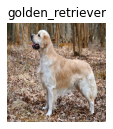

In [28]:
show_predictions(infer)

# Task 9: Convert to TF-TRT Float16 and Benchmark

In this task, you will update the convert_to_trt_graph_and_save function you worked with in the last task to be able to also perform conversion for Float16 precision.

In [29]:
convert_to_trt_graph_and_save(precision_mode='float16',input_saved_model_dir= 'inceptionv3_saved_model')

INFO:tensorflow:Linked TensorRT version: (5, 1, 5)
INFO:tensorflow:Loaded TensorRT version: (5, 1, 5)
INFO:tensorflow:Running against TensorRT version 5.1.5
Converting inceptionv3_saved_model to TF-TRT graph precision mode FP16...
Saving converted model to inceptionv3_saved_model_TFTRT_FP16
INFO:tensorflow:Assets written to: inceptionv3_saved_model_TFTRT_FP16/assets
Conversion complete


Load the optimized TF model.

In [30]:
saved_model_loaded =  load_tf_saved_model('inceptionv3_saved_model_TFTRT_FP16')
infer = saved_model_loaded.signatures['serving_default']

Loading saved model inceptionv3_saved_model_TFTRT_FP16...


Perform inference with the optimized graph, and after a warmup, time and calculate throughput.

In [31]:
all_preds = predict_and_benchmark_throughput(batched_input, infer)

Steps 0-50 average: 58.0ms
Steps 50-100 average: 57.8ms
Steps 100-150 average: 58.1ms
Steps 150-200 average: 57.9ms
Steps 200-250 average: 57.4ms
Steps 250-300 average: 58.0ms
Steps 300-350 average: 58.2ms
Steps 350-400 average: 57.7ms
Steps 400-450 average: 57.3ms
Steps 450-500 average: 57.8ms
Steps 500-550 average: 58.0ms
Steps 550-600 average: 58.3ms
Steps 600-650 average: 58.2ms
Steps 650-700 average: 58.3ms
Steps 700-750 average: 58.1ms
Steps 750-800 average: 57.5ms
Steps 800-850 average: 57.5ms
Steps 850-900 average: 57.5ms
Steps 900-950 average: 57.7ms
Steps 950-1000 average: 57.9ms
Throughput: 553 images/s


Before going to the next Task, please execute the cell below to restart the kernel and clear GPU memory.

In [24]:
import IPython
IPython.Application.instance().kernel.do_shutdown(True)

{'restart': True, 'status': 'ok'}

## Task 10: TF-TRT INT8 Model

We will discuss how TF-TRT is able to optimize to use Int8 precision.

## Benefits of Reduced Precision Inference

Typically, model training is performed using 32-bit floating point mathematics. Due to the backpropagation algorithm and weights updates, this high precision is necessary to allow for model convergence. Once trained, inference could be done in reduced precision (e.g. FP16) as the neural network architecture only requires a feed-forward network.

Reducing numerical precision allows for a smaller model with faster inferencing time, lower memory requirements, and more throughput.

Furthermore, recent NVIDIA GPUs are capable of executing 8-bit integer 4-element vector dot product instructions to accelerate deep neural network inference. 

[Source](https://developer.nvidia.com/blog/int8-inference-autonomous-vehicles-tensorrt/): Fast INT8 Inference for Autonomous Vehicles with TensorRT 3

<div align="center">
    <img src='https://developer.nvidia.com/blog/wp-content/uploads/2017/12/dp4a-updated.png' />
    <p style="text-align: center;color:gray"> Figure (d). The DP4A instruction: 4-element dot product with accumulation.</p>
</div>

## Reduced Dynamic Range of INT8

"While this new instruction provides faster computation, there is a significant challenge in representing weights and activations of deep neural networks in this reduced INT8 format. As *Table 1* shows, the dynamic range and granularity of representable values for INT8 is significantly limited compared to FP32 or FP16." [Source](https://developer.nvidia.com/blog/int8-inference-autonomous-vehicles-tensorrt/)

[Source](https://on-demand.gputechconf.com/gtc/2017/presentation/s7310-8-bit-inference-with-tensorrt.pdf): 8-bit Inference with TensorRT

<div align="center">
    <img src='https://kezunlin.me/images/posts/635233-20181119142909032-2033014099.png' />
    <p style="text-align: center;color:gray"> Table 1. Dynamic range of FP32, FP16 and INT8.</p>
</div>

## TF-TRT INT8 Quantization

You might be wondering how it is possible to take a model which operates in 32 bit floating point precision, where you can represent billions of different numbers, and reduce that to only 8 bit integers which can only represent 256 possible values.

The main reason is that, typically in deep learning, the values of weights and activations lie in very small ranges. So if we design our precious 8 bits to only represent this specific small range, we can usually maintain good accuracy while reducing the rounding error.

The main challenge is to find the correct dynamic range of the inputs. TF-TRT uses a calibration process that minimizes the information loss when approximating the FP32 network with a limited 8-bit integer representation. In the next Task, you will see how to perform this calibration process.

[Source](https://blog.tensorflow.org/2019/06/high-performance-inference-with-TensorRT.html): High performance inference with TensorRT Integration 

<div align="center">
    <img width="600px" src='https://2.bp.blogspot.com/-UiS1VGo7zwQ/XflUnggwnYI/AAAAAAAAB5g/yU5qOXVfWw0x8oYaKyRcd4AKsbBltU64ACLcBGAsYHQ/s1600/fig7.png' />
</div>

Further quantization details: [https://developer.nvidia.com/gtc/2019/video/S9431/video](https://developer.nvidia.com/gtc/2019/video/S9431/video)

### Calibration Dataset Considerations

When preparing the calibration dataset, you should capture the expected distribution of data in typical inference scenarios. You need to make sure that the calibration dataset covers all the expected scenarios, for example, clear weather, rainy day, night scenes, etc. When examining your own dataset, you should create a separate calibration dataset. The calibration dataset shouldn’t overlap with the training, validation or test datasets. 

## Task 11: Converting to TF-TRT INT8

You will convert a TensorFlow saved model into a TF-TRT optimized graph using INT8 precision.

In [10]:
convert_to_trt_graph_and_save(precision_mode='int8', input_saved_model_dir='inceptionv3_saved_model')

INFO:tensorflow:Linked TensorRT version: (5, 1, 5)
INFO:tensorflow:Loaded TensorRT version: (5, 1, 5)
INFO:tensorflow:Running against TensorRT version 5.1.5
Converting inceptionv3_saved_model to TF-TRT graph precision mode INT8...
Saving converted model to inceptionv3_saved_model_TFTRT_INT8
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: inceptionv3_saved_model_TFTRT_INT8/assets
Conversion complete


## Task 12: Benchmark TF-TRT INT8

You will use the optimized graph to make predictions and will benchmark its performance.

In [11]:
saved_model_loaded = load_tf_saved_model('inceptionv3_saved_model_TFTRT_INT8')
infer = saved_model_loaded.signatures['serving_default']

Loading saved model inceptionv3_saved_model_TFTRT_INT8...


In [12]:
all_preds= predict_and_benchmark_throughput(batched_input, infer, N_warmup_run=50,N_run=1000)

Steps 0-50 average: 35.4ms
Steps 50-100 average: 35.5ms
Steps 100-150 average: 35.6ms
Steps 150-200 average: 35.9ms
Steps 200-250 average: 35.8ms
Steps 250-300 average: 36.0ms
Steps 300-350 average: 36.2ms
Steps 350-400 average: 36.2ms
Steps 400-450 average: 35.8ms
Steps 450-500 average: 36.0ms
Steps 500-550 average: 36.1ms
Steps 550-600 average: 35.8ms
Steps 600-650 average: 35.4ms
Steps 650-700 average: 35.4ms
Steps 700-750 average: 35.6ms
Steps 750-800 average: 35.5ms
Steps 800-850 average: 35.7ms
Steps 850-900 average: 35.8ms
Steps 900-950 average: 35.7ms
Steps 950-1000 average: 36.1ms
Throughput: 894 images/s


./data/img0.JPG - Predicted: [('n02099601', 'golden_retriever', 0.6143656), ('n02099712', 'Labrador_retriever', 0.23844576), ('n02104029', 'kuvasz', 0.0067298734)]


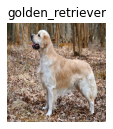

In [13]:
show_predictions(infer)

## Conclusion
In this notebook, we have demonstrated the process of creating TF-TRT FP32, FP16 and INT8 inference models from an original Keras FP32 model, as well as verify their speed and accuracy. 
